In [1]:
import phoebe
import numpy as np
from transformer_payne import Blackbody

from spice.models import PhoebeModel
from spice.spectrum import simulate_observed_flux
%matplotlib inline
from phoebe.parameters.dataset import _mesh_columns
import astropy.units as u

from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
logger = phoebe.logger()

b = phoebe.default_star()
times = np.array([0.])
b.add_dataset('lc', compute_times=times, dataset='lc01')
b.add_dataset('mesh', compute_times=times, columns=_mesh_columns + ['pblum_ext@lc01', 'ldint@lc01', 'ptfarea@lc01', 'abs_normal_intensities@lc01','normal_intensities@lc01'])
b.set_value('irrad_method', 'none')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.])
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_func_bol', 'linear')
b.set_value_all('ld_coeffs_bol', [0.])
b.set_value_all('atm', 'blackbody')
b.set_value('distance', 1*u.AU.to(u.m))
b.set_value('teff', 5772.)
b.compute_pblums()
b.run_compute(irrad_method='none')

100%|██████████| 1/1 [00:00<00:00, 68.88it/s]


<ParameterSet: 40 parameters | kinds: lc, mesh>

Mon, 02 Jun 2025 12:12 matplotlib.axes._base WARNING Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


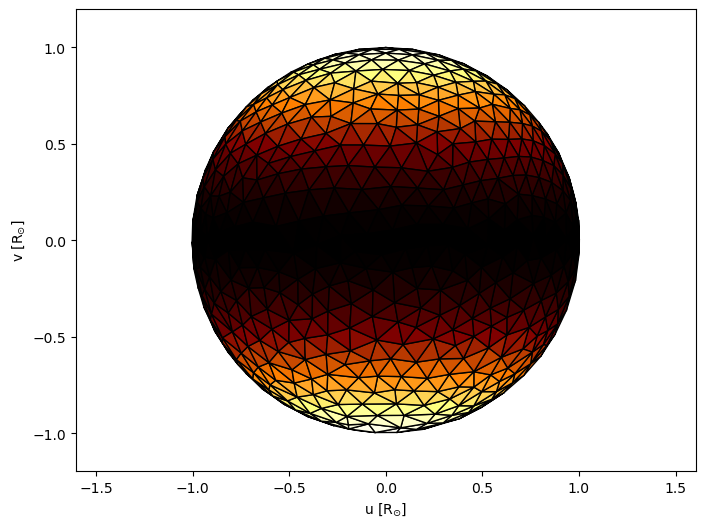

In [3]:
afig, mplfig = b.filter(time=0.).plot(fc='teffs', show=True)

In [4]:
b.get_parameter('pblum_ext@lc01')

<Parameter: pblum_ext=12.566370614359172 W | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

In [5]:
-2.5*np.log10(b.get_parameter('pblum_ext@lc01').value)++ 71.1974

68.44937533994477

In [6]:
b.get_parameter('pblum_ext@lc01').description

'Passband Luminosity of entire star (after pblum scaling)'

In [7]:
from spice.models import PhoebeModel
from spice.models.phoebe_utils import PhoebeConfig, Component

p1 = PhoebeConfig(b, 'mesh01')
bb = Blackbody()
ps = PhoebeModel.construct(p1, 0., bb.parameter_names, {pn: sp for pn, sp in zip(bb.parameter_names, bb.solar_parameters)}, component='starA')

In [8]:
ws = np.linspace(900, 40000, 10)
s1 = simulate_observed_flux(bb.intensity, ps, np.log10(ws))

In [9]:
np.sum(b.get_parameter('normal_intensities@lc01').value)

1.2914630691376525e-08

In [10]:
np.sum(b.get_parameter('abs_normal_intensities@lc01').value)

4.364523414467152e+16

In [11]:
np.sum(s1[:, 0])

Array(0.00743457, dtype=float32)

In [12]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import Bolometric

bolometric = Bolometric()
lum = AB_passband_luminosity(bolometric, ws, s1[:, 0])